In [26]:
import math
from ast import literal_eval

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.subplots as sp
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.parametrize as parametrize
from matrepr import mdisplay
from plotly.subplots import make_subplots
from rich import print as rprint
from safetensors.torch import load_file, load_model
from torch import linalg
from torch.nn.utils.parametrizations import orthogonal
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics import MulticlassAccuracy

from koopmann import aesthetics
from koopmann.data import (
    DatasetConfig,
    create_data_loader,
    get_dataset_class,
)
from koopmann.models import MLP, Autoencoder, ExponentialKoopmanAutencoder
from koopmann.models.utils import (
    get_device,
    pad_act,
    parse_safetensors_metadata,
)

# from koopmann.utils import compute_model_accuracy
from koopmann.visualization import plot_eigenvalues

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
task = "mnist"
scale_idx = "0"
k = "1"
dim = "1024"
user = "nsa325"
use_exponential = False

In [28]:
model_name = f"{task}_probed"
ae_name = f"{task}_model"

# Original model path
model_file_path = f"/scratch/{user}/koopmann_model_saves/{model_name}.safetensors"

# Autoenoder path in work dir
ae_file_path = f"/scratch/{user}/koopmann_model_saves/scaling/k_{k}_dim_{dim}_loc_{scale_idx}_autoencoder_{ae_name}.safetensors"

In [29]:
model, _ = MLP.load_model(model_file_path)
model.modules[-2].remove_nonlinearity()
# model.modules[-3].update_nonlinearity("leakyrelu")
model.modules[-3].remove_nonlinearity()
model.eval()
model.hook_model()

In [30]:
metadata = parse_safetensors_metadata(file_path=model_file_path)
dataset_config = DatasetConfig(
    dataset_name=metadata["dataset"],
    num_samples=5_000,
    split="test",
    seed=21,
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config)
dataloader = create_data_loader(dataset, batch_size=4096)

In [31]:
# Parse metadata
metadata = parse_safetensors_metadata(file_path=ae_file_path)

# Choose model based on flag
AutoencoderClass = ExponentialKoopmanAutencoder if use_exponential else Autoencoder

# Instantiate model
autoencoder = AutoencoderClass(
    input_dimension=literal_eval(metadata["input_dimension"]),
    latent_dimension=literal_eval(metadata["latent_dimension"]),
    nonlinearity=metadata["nonlinearity"],
    k=literal_eval(metadata["steps"]),
    batchnorm=literal_eval(metadata["batchnorm"]),
    hidden_configuration=literal_eval(metadata["hidden_configuration"]),
)

# Load weights
load_model(autoencoder, ae_file_path, device="cpu", strict=True)
autoencoder.eval()

k = literal_eval(metadata["num_scaled"])
print(f"Little K: {k}")

Little K: 1


In [32]:
K_matrix = autoencoder.koopman_matrix.linear_layer.weight.T.detach()

In [33]:
images, labels = next(iter(dataloader))
target_images = images[torch.where((labels == 0))]

In [34]:
with torch.no_grad():
    x = target_images.flatten(start_dim=1)

    _ = model(x)

    # TODO: This is quick and dirty
    ###############################################################
    # Undo MNIST standardization: X_original = X_standardized * std + mean
    x = x * 0.3081 + 0.1307

    # Convert [0,1] range to [-1,1]
    x = 2 * x - 1
    ###############################################################

    x_obs = autoencoder._encode(x)
    x_recon = autoencoder._decode(x_obs)

    act = model.get_fwd_activations()[4]
    act_obs = autoencoder._encode(act)
    act_recon = autoencoder._decode(act_obs)

    pred_act_obs = x_obs @ torch.linalg.matrix_power(K_matrix, k)
    pred_act = autoencoder._decode(pred_act_obs)

In [35]:
# Convert to DataFrame
df = pd.DataFrame(x_obs)

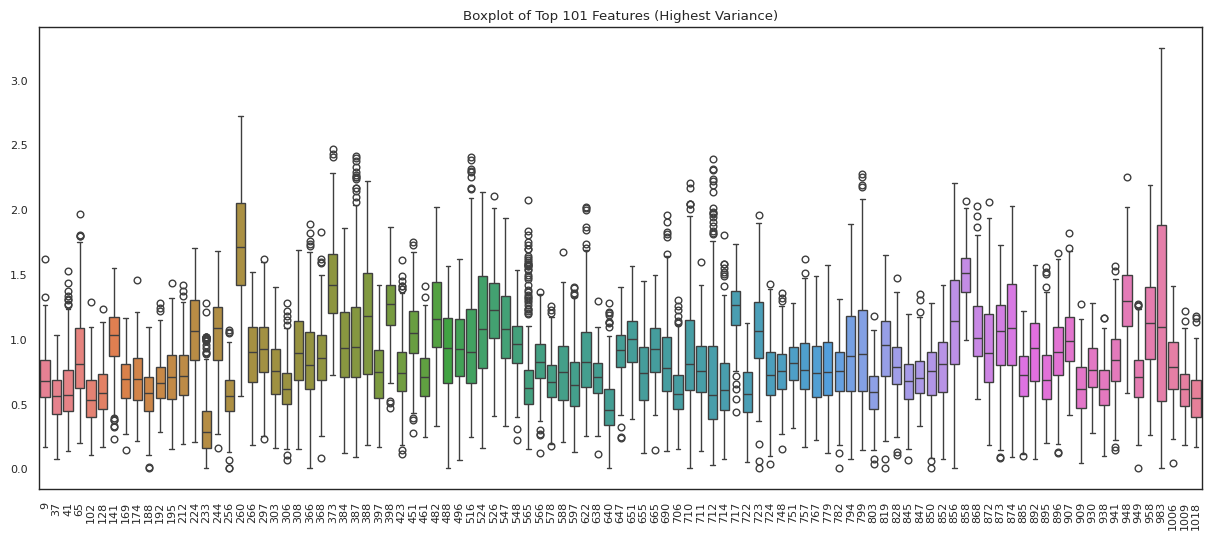

In [52]:
k = 101

# Compute variance per feature
feature_variance = df.var(axis=0)

top_features = feature_variance.nlargest(k).index
df_top = df[top_features]

# Plot
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_top)
plt.xticks(rotation=90)
plt.title(f"Boxplot of Top {k} Features (Highest Variance)")
plt.show()


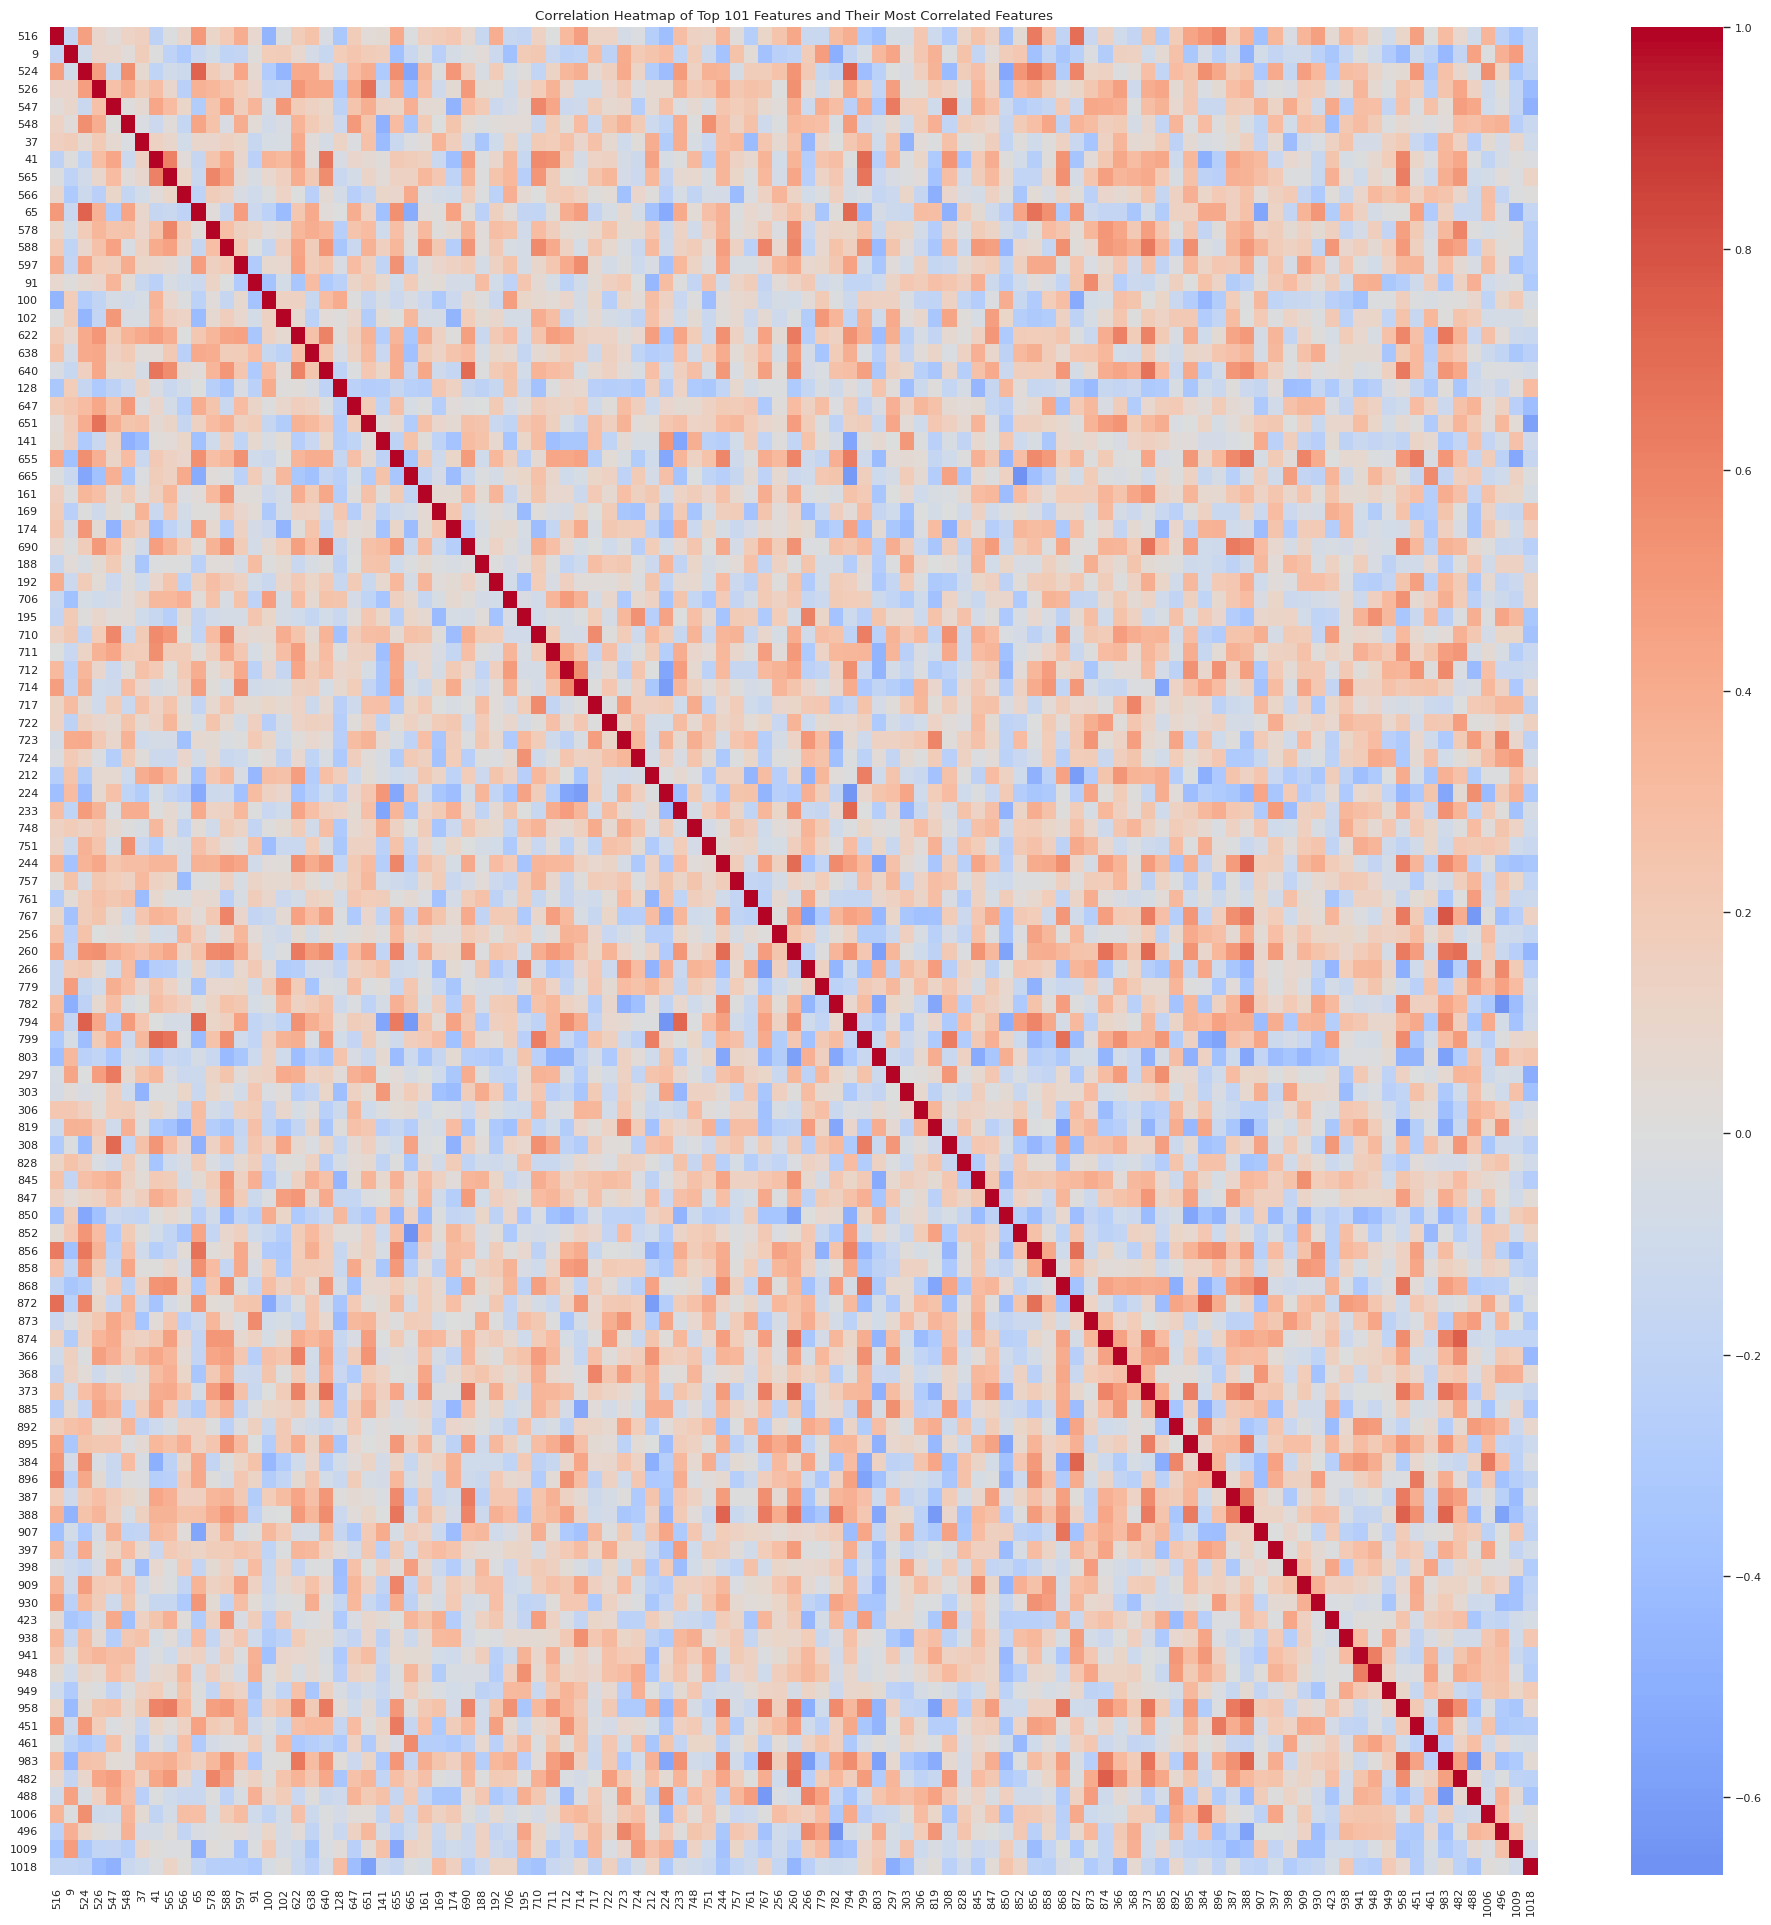

In [53]:
# Compute correlation matrix
corr_matrix = df.corr()

# Extract the correlation of all features with the top `k` varied features
top_k_corr = corr_matrix.loc[:, top_features]  # Get correlation for selected features
m = 5  # Number of strongest covarying features per top feature
most_covarying_features_corr = {}

for feature in top_features:
    most_covarying_features_corr[feature] = (
        top_k_corr[feature].abs().nlargest(m + 1).iloc[1:].index.tolist()
    )  # Exclude self

# # Print the results
# for key, value in most_covarying_features_corr.items():
#     print(f"Top {m} features most correlated with {key}: {value}")

# Get unique most correlated features
unique_covarying_features = list(set(sum(most_covarying_features_corr.values(), [])))

# Combine top varied features with their strongest correlated ones
features_to_plot_corr = list(set(list(top_features) + unique_covarying_features))

# Filter correlation matrix to only relevant features
corr_subset = df[features_to_plot_corr].corr()

# Plot heatmap
plt.figure(figsize=(24, 24))
sns.heatmap(corr_subset, cmap="coolwarm", center=0)
plt.title(f"Correlation Heatmap of Top {k} Features and Their Most Correlated Features")
plt.show()
